In [ ]:
"""
CancerDiscovery
Figure 3
Spatial Analysis

This notebook follows the following analysis format
- Processing
- QC
- Neighbors analysis 
- Representative spatial slide plots
- Heatmapping 
- Distance analysis
"""

__author__ = "Daniel Ranti"
__credits__ = "Yuan-Shuo Wang"
__license__ = "Open Access"
__version__ = "1.0.1"
__maintainer__ = "Daniel Ranti"
__email__ = "daniel.l.ranti@gmail.com"
__status__ = "Development"

In [ ]:
######################################
# Imports, global variables, functions
######################################

import os
# Set directory for data
os.chdir('/sc/arion/projects/nmibc_bcg/CancerDiscovery/data/spatial')
FIGURE_DIR = '/sc/arion/projects/nmibc_bcg/CancerDiscovery/analyses/spatial_figures'

# Spatial Tools
from anndata import AnnData
import scanpy as sc
import scanpy.external as sce
import squidpy as sq
import SpatialDE

# General Data Science Tools
import pandas as pd
import numpy as np
import scipy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from adjustText import adjust_text

import gseapy as gp

# To prevent warnings from making output look bad
import warnings
warnings.filterwarnings("ignore")

sc.set_figure_params(facecolor="white", figsize=(8, 8), transparent=True, fontsize=14, dpi_save=200, dpi=100)
sc.settings.verbosity = 3

def read_10x_path_list(path_list, sample_ids):
    '''
    reads in a path list and a list of samples IDs for each path
    outputs a list of visum adata objects, each labelled with the 
    associated ID
    '''
    visium_adata_list = []
    for path, sample_id in zip(path_list, sample_ids):
        temp = sc.read_visium(path)
        temp.obs['sample_id'] = sample_id
        temp.var_names_make_unique()
        sc.pp.calculate_qc_metrics(temp,inplace=True)
        visium_adata_list.append(temp)
    return visium_adata_list

from adjustText import adjust_text

def label_cell_probabilities(spatial_adata, cell_columns, percentile_cutoff=0.50):
    """
    returns binarized cell indicators based on a percentile cutoff 
    spatial_adata: adata structure that includes visium dot probabilities in obs
    cell_columns: list of columns of interest
    percentile_cutoff: float between 0 and 1. 
    """
    for cell_type in cell_columns:
        newcol = cell_type+' bool'
        spatial_adata.obs[newcol] = spatial_adata.obs[cell_type].apply(lambda x: 1 if x >= percentile_cutoff else 0)
    return spatial_adata
    

# Analyses: Preprocessing

In [ ]:
#######################################
# Cleaning, concatenating and combining
#######################################

old_labels_to_drop = [
    'Tumor Cell_x',
    'T Cell_x',
    'B Cell_x',
    'Monocyte/Macrophage_x', 
    'CD8+ T Cell_x',
    'Stroma_x',
    'NK Cell_x',
    'Fibroblast_x',
    'Plasma Cell_x',
    'unknown_x',
    'Endothelial Cell_x',
    'Mature DC_x',
    'Tumor Cell_y',
    'T Cell_y',
    'B Cell_y',
    'Monocyte/Macrophage_y', 
    'CD8+ T Cell_y',
    'Stroma_y',
    'NK Cell_y',
    'Fibroblast_y',
    'Plasma Cell_y',
    'unknown_y',
    'Endothelial Cell_y',
    'Mature DC_y',   
    'Tumor Cell',
    'T Cell',
    'B Cell',
    'Monocyte/Macrophage', 
    'CD8+ T Cell',
    'Stroma',
    'NK Cell',
    'Fibroblast',
    'Plasma Cell',
    'unknown',
    'Endothelial Cell',
    'Mature DC'
]

# https://github.com/broadinstitute/Tangram/blob/master/tangram/plot_utils.py
# Recreating label probabilities from RNA-density estimations based on the tangram github account's methods
labelled = sc.read_h5ad('labelled_spatial_tangram_1000genes_realigned.h5ad')
labelled.obs.drop(old_labels_to_drop, axis=1, inplace=True)
df_plot = labelled.obsm['tangram_ct_pred']
labels = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())
labels.mean(axis=1)

# Replacing labelled.obs with the updated obs including probabilities
labelled.obs = pd.merge(labelled.obs, labels, left_index=True, right_index=True)

# Adding in clinical information 
cell_columns = [
    'Tumor Cell', 'T Cell', 'B Cell', 'Monocyte/Macrophage', 
    'CD8+ T Cell', 'Stroma', 'NK Cell', 'Fibroblast', 'Plasma Cell', 
    'unknown','Endothelial Cell', 'Mature DC']

# labelled.obs[cell_columns].apply(lambda x: 1 if x > percentile_cutoff else 0)
binarized = label_cell_probabilities(labelled,cell_columns, 0.50)

# Number of labelled cell types at 50% cutoff.
cell_bool = [item+' bool' for item in cell_columns]
binarized.obs[cell_bool].sum(axis=0).sort_values()

# Calculating label counts
binarized.obs[cell_bool].sum(axis=1).value_counts().reset_index()
binarized.obs['label_count'] = binarized.obs[cell_bool].sum(axis=1)

# Cell Labels
def label_visium_condition(row):    
    if row['label_count'] == 0:
        return 'Unlabelled'
    elif row['label_count'] == 1 and row['Tumor Cell bool'] == 1:
        return 'Uninfiltrated Tumor'
    elif row['label_count'] > 1 and row['Tumor Cell bool'] == 1 and row['CD8+ T Cell bool'] == 1:
        return 'Infiltrated Tumor + CD8+ T'
    elif row['label_count'] > 1 and row['Tumor Cell bool'] == 1 and row['T Cell bool'] == 1:
        return 'Infiltrated Tumor + T Cell'
    elif row['NK Cell bool'] == 1:
        return 'NK Cell'
    elif row['label_count'] == 1 and row['T Cell bool'] == 1:
        return 'T Cell (Alone)'
    elif row['label_count'] == 1 and row['CD8+ T Cell bool'] == 1:
        return 'CD8+ T Cell (Alone)'
    elif row['label_count'] > 1 and row['Tumor Cell bool'] == 1:
        return 'Infiltrated Tumor + Other'
    else: 
        return 'Other'

binarized.obs['visium_dot_label'] = binarized.obs.apply(lambda row: label_visium_condition(row), axis=1)

spatial_palette = {
    'Unlabelled':'dimgray',
    'Uninfiltrated Tumor':'white',
    'Infiltrated Tumor + CD8+ T':'orange',
    'Infiltrated Tumor + T Cell':'chartreuse',
    'NK Cell':'aqua',
    'Infiltrated Tumor + Other':'Red',
    'NK Cell (Alone)':'hotpink',
    'CD8+ T Cell (Alone)':'deeppink',
    'T Cell (Alone)':'pink',
    'Other':'black',
}

# Add clinical labels
clinical_info = pd.read_excel('spatial_clinical_anon.xlsx')
clinical_info = clinical_info.rename({'BRP ID#':'sample_id','Characterization':'bcg_status'}, axis=1)
clinical_info['sample_id'] = clinical_info['sample_id'].astype('str')
binarized.obs['sample_id'] = binarized.obs['sample_id'].astype('str')

obs_plus_clinical = pd.merge(binarized.obs, clinical_info[['sample_id', 'bcg_status']], left_on='sample_id', right_on='sample_id')
obs_plus_clinical.index = binarized.obs.index
binarized.obs = obs_plus_clinical
binarized.var.index = [item.upper() for item in binarized.var.index]


In [ ]:
#########################
# Looking at TREG markers
#########################

of_interest = ['CCR8','CCL1','IL-10','TGFB1','ENTPD1','CTLA-4','IL-2RA','LAG3','LAYN','CCR8',]
treg_markers = [item for item in of_interest if item in binarized.var.index]
for marker in treg_markers:
    binarized.obs['{}_status'.format(marker)] = pd.DataFrame(binarized[:,'{}'.format(marker)].X.toarray() > 0, index=binarized.obs.index)

def label_tregs(row):
    if (row['T Cell bool'] == 1) & (row['ENTPD1_status'] == True) & (row['LAYN_status'] == True) & (row['TGFB1_status'] == True):
        treg = 1
        cd4 = 0
    elif (row['T Cell bool'] == 1):
        treg=0
        cd4=1
    else:
        treg=0
        cd4=0
    return treg, cd4 
# Assigning labels and unpacking
temp = binarized.obs.apply(lambda row: label_tregs(row), axis=1)
temp = pd.DataFrame(temp.to_list(),index=temp.index, columns=['TREG bool', 'CD4+ bool'])
binarized.obs = pd.merge(binarized.obs, temp, left_index=True, right_index=True)

In [ ]:
# double checking that we didnt accidentally assign some non-T Bool columns to be a CD4
binarized.obs[['TREG bool', 'CD4+ bool', 'T Cell bool']].value_counts()

# Quality Control

In [ ]:
########################################
# QC: labelled vs unlabelled gene counts
########################################

fig, ax = plt.subplots(1, 2, figsize=(12,5))

binarized.obs[binarized.obs.visium_dot_label == 'Unlabelled'].n_genes_by_counts.plot.hist(ax=ax[0])
ax[0].set_title('Unlabelled Visium Dots')
ax[0].set_xlabel('Gene Count')
ax[0].set_ylabel('n Visium Dots')

binarized.obs[~(binarized.obs.visium_dot_label == 'Unlabelled')].n_genes_by_counts.plot.hist(ax=ax[1])
ax[1].set_title('Labelled Visium Dots')
ax[1].set_xlabel('Gene Count')
ax[1].set_ylabel('n Visium Dots')
fig.savefig(FIGURE_DIR+'/QC: labelled vs unlabelled visium dots.png', dpi=200)

In [ ]:
############
# Pre-BCG QC
############

pre_BCG_samples = ['28537', '30150', '20121']

# Plot Pre-BCG 
fig, ax = plt.subplots(1,3, figsize=(20,10))
for sample, ax in zip(pre_BCG_samples, fig.axes ):
    sc.pl.spatial(
        binarized[binarized.obs.sample_id == sample], 
        title=sample, 
        library_id = sample, 
        palette=spatial_palette,
        ax=ax,
        color='visium_dot_label', 
        legend_loc='bottom'
    )
plt.subplots_adjust(wspace=100, hspace=100)
fig.savefig(FIGURE_DIR+'/QC:prebcg labelled.png', bbox_inches='tight',dpi=200)

# Neighbors

In [ ]:
####################
# Neighbors analysis
####################

spatial_list = []

for sample_id in set(binarized.obs.sample_id):
    print(sample_id)
    adata_temp = binarized[(binarized.obs.sample_id == sample_id)]
    sq.gr.spatial_neighbors(adata_temp, coord_type="grid", n_rings=2) #n_neighs=6)
    for counter in range(adata_temp.shape[0]-1):
        # row by row generating a boolean map of neighbors
        neighbors = adata_temp.obsp['spatial_connectivities'][counter,:].todense().tolist()[0]
        temp_dict = adata_temp.obs[list(map(bool,neighbors))]['visium_dot_label'].value_counts().to_dict()
        # row by row counting neighboring tumor cells
        temp_dict['n_neigh_tumors'] = adata_temp.obs[list(map(bool,neighbors))]['Tumor Cell bool'].sum()
        # also need to assign cd4+/NK/ outside of treg
        temp_dict['n_neigh_CD4+'] = adata_temp.obs[list(map(bool,neighbors))]['CD4+ bool'].sum()
        temp_dict['n_neigh_CD8+'] = adata_temp.obs[list(map(bool,neighbors))]['CD8+ T Cell bool'].sum()
        temp_dict['n_neigh_treg'] = adata_temp.obs[list(map(bool,neighbors))]['TREG bool'].sum()
        temp_dict['n_neigh_NK'] = adata_temp.obs[list(map(bool,neighbors))]['NK Cell bool'].sum()
        temp_dict['index'] = adata_temp[counter,:].obs.index.values[0]
        spatial_list.append(temp_dict)

# create neighbors count df to append to existing obs df
neighbors_count = pd.DataFrame(spatial_list).fillna(0)
neighbors_count.set_index('index', inplace=True)
new_cols = []
# rewrite column names
for item in neighbors_count.columns:
    new_cols.append('Neighbor_count:'+item)
neighbors_count.columns = new_cols
# append with the existing df using index to match up rows 
binarized.obs = pd.concat([binarized.obs, neighbors_count], axis=1)
binarized.layers['scaled'] = sc.pp.scale(binarized, copy=True).X

# # total T count
# binarized.obs['Neighbor_count:Total T count'] = binarized.obs[[
#     'Neighbor_count:Infiltrated Tumor + T Cell',
#     'Neighbor_count:Infiltrated Tumor + CD8+ T',
#     'Neighbor_count:T Cell (Alone)', 
#     'Neighbor_count:CD8+ T Cell (Alone)',]].sum(axis=1)

# binarized.obs['Neighbor_count:Total CD8T'] = binarized.obs[[
#     'Neighbor_count:Infiltrated Tumor + CD8+ T',
#     'Neighbor_count:CD8+ T Cell (Alone)',]].sum(axis=1)


In [ ]:
####################################
# HLA-E Bright vs Dim: Visualization
####################################

## Histogram of HLA-E
tumor_only = binarized[binarized.obs['Tumor Cell bool'] == 1]
hlae_measurements = pd.DataFrame(scipy.sparse.csc_matrix.todense(tumor_only[:,tumor_only.var.index == 'HLA-E'].X)).rename({0:'HLA-E'}, axis=1)

## HLA-E Quantiles
hlae_25 = np.quantile(hlae_measurements,0.25)
hlae_75 = np.quantile(hlae_measurements,0.75)

ax = sns.histplot(data=hlae_measurements, x="HLA-E")
ax.title.set_text('HLA-E Histogram')
plt.axvline(hlae_75, 0,3000, color='red', label='HLA-E High')
plt.axvline(hlae_25, 0,3000, color='black', label='HLA-E Low')
plt.legend()
plt.savefig('QC: Histogram of HLA-E.png', dpi=200)


In [ ]:
######################################
# HLA-E Bright vs Dim: Data Assignment
######################################

## Assigning HLA-E Bright vs Dim
temp_obs = tumor_only.obs
hlae_measurements.index = tumor_only.obs.index
temp_obs['HLA-E'] = hlae_measurements

# I have no idea but for some reason this needs to 
# run twice in order for the next cell to work
temp_obs = tumor_only.obs
hlae_measurements.index = tumor_only.obs.index
temp_obs['HLA-E'] = hlae_measurements

In [ ]:
# Brief Lambda Function
def label_hla_e(row):
    '''
    To assign HLA-E labels
    '''
    if row['HLA-E'] >= hlae_75: 
        return 'High'
    elif row['HLA-E'] <= hlae_25:
        return 'Low'
    else: 
        return 'Middle'

temp_obs['HLA-E Label'] = temp_obs.apply(lambda row: label_hla_e(row), axis=1)
tumor_only.obs = temp_obs

# Looking at only tumor with assigned high and low HLA-E Labels. 
hlae_HL_tumor = tumor_only[tumor_only.obs['HLA-E Label'].isin(['High', 'Low']),:]

# Representative Spatial Plots

In [ ]:
####################################
# Figure 3 Panel F: Z scaled Heatmap
####################################

tumor_only.obs = tumor_only.obs.rename({'HLA-E': 'HLA-E Level'},axis=1)
tumor_only_under13 = tumor_only[
    (tumor_only.obs['Neighbor_count:n_neigh_CD4+'].isin([0,1,2,3,4,5,6,7,8,9,10,11,12,13]))
]
tumor_only_under13.layers['scaled'] = sc.pp.scale(tumor_only_under13, copy=True).X
tumor_only_under13.obs['Neighbor_count:n_neigh_CD4+'] = pd.Categorical(tumor_only_under13.obs['Neighbor_count:n_neigh_CD4+'])

sc.set_figure_params(fontsize=15)
checkpoint_ligands = {
    'Inhibitory':['CD47','CD274','PDCD2','HLA-A','HLA-B','HLA-C', 'HLA-E'], 
    'Stimulatory':['CD58',],
    'Inf. Recep': ['IFNGR1','IFNGR2'],
    'Inf. Pathway': ['JAK1','JAK2', 'STAT1','STAT3','IRF1','IRF9','SOCS1', 'FAS'],
}

with plt.rc_context({"figure.dpi": (100)}):
    mp = sc.pl.matrixplot(
        tumor_only_under13, 
        var_names=checkpoint_ligands,
        figsize=(9,7),
        groupby='Neighbor_count:n_neigh_CD4+',
        colorbar_title='Mean Z-Score', 
        layer='scaled', 
        dendrogram=False,
        swap_axes=True,
        vmin=-1, 
        vmax=1,
        return_fig=True,
        cmap='RdBu_r', 
    )
    mp.add_totals().show()
    mp.savefig(FIGURE_DIR+'/Figure 3 Panel F (Total T).png')


In [ ]:
#########################################
# Figure 3 Panel F: Column scaled Heatmap
#########################################

with plt.rc_context({"figure.dpi": (100)}):
    mp = sc.pl.matrixplot(
        tumor_only_under13, 
        var_names=checkpoint_ligands,
        figsize=(9,7),
        groupby='Neighbor_count:n_neigh_CD4+',
        colorbar_title='Row Scaled Exp.', 
        standard_scale='var',
        dendrogram=False,
        swap_axes=True,
        return_fig=True,
        cmap='Blues', 
    )
    mp.add_totals().show()
    mp.savefig(FIGURE_DIR+'/Figure 3 Panel F (Column Scaled Total CD4+).png')


In [ ]:
#########################################
# Figure 3 Panel F: statistical significance
#########################################

sc.tl.rank_genes_groups(
    tumor_only_under13, 
    groupby='Neighbor_count:n_neigh_CD4+', 
    method='wilcoxon', 
    reference=0
)

logfold_df = sc.get.rank_genes_groups_df(tumor_only_under13, group=None)

logfold_df[
    (logfold_df['names'].isin(['CD47','CD274','PDCD2','HLA-A','HLA-B','HLA-C', 'HLA-E','CD58','IFNGR1','IFNGR2','JAK1','JAK2', 'STAT1','STAT3','IRF1','IRF9','SOCS1', 'FAS'])) & 
    (logfold_df['pvals_adj'] < 0.05)
].sort_values('names')

In [ ]:
logfold_df[
    (logfold_df['names'].isin(['CD47','CD274','PDCD2','HLA-A','HLA-B','HLA-C', 'HLA-E','CD58','IFNGR1','IFNGR2','JAK1','JAK2', 'STAT1','STAT3','IRF1','IRF9','SOCS1', 'FAS'])) & 
    (logfold_df['pvals_adj'] < 0.05)
].sort_values('names').to_csv(FIGURE_DIR+'/tumor_neighboring_cd4.csv')

## Representative Spatial Plots (Panel A - F)

In [ ]:
#######################################
# FIGURE 3 PANEL A: NEIGHBORING T CELLS
#######################################

# Subset to 16235
bin_16235 = binarized[binarized.obs.sample_id == '16235']
bin_16235.obs['Neighbor_count:CD8+NK'] = bin_16235.obs['Neighbor_count:n_neigh_CD8+'] + bin_16235.obs['Neighbor_count:NK Cell']
hlae_col = pd.DataFrame(scipy.sparse.csc_matrix.todense(bin_16235[:,bin_16235.var.index == 'HLA-E'].X > 0)).rename({0:'HLA-E'}, axis=1)
hlae_col.index = bin_16235.obs.index
bin_16235.obs['HLA-E'] = hlae_col

# subset on hlae
hlae_only = bin_16235[bin_16235.obs['HLA-E'] == True]

# KDE DF with binarized HLA-E
kde_plot = pd.DataFrame(hlae_only.obsm['spatial'], columns = ('spatial_1', 'spatial_2'))

# Custom color palette 
custom_palette = ('#020069', '#04b306', '#ddf23d', '#f3f7d2')
cmap = LinearSegmentedColormap.from_list('Custom', custom_palette, len(custom_palette))

# Make figure
sns.set_style("white")
with plt.rc_context({"figure.figsize": (10, 8), "figure.frameon": False}):
    fig, ax = plt.subplots(1)
    manual_spatial_plot = pd.DataFrame(bin_16235.obsm['spatial']).rename({0:'spatial_1',1:'spatial_2'},axis=1)
    # total T cell counts. 
    manual_spatial_plot['Total T'] = bin_16235.obs['Neighbor_count:n_neigh_CD4+'].values
#     manual_spatial_plot['Total T'] = bin_16235.obs['Neighbor_count:CD8+NK'].values
    sns.scatterplot(
        data=manual_spatial_plot, 
        x="spatial_1", 
        y="spatial_2",
        s=30, 
        hue='Total T', 
        palette='Spectral_r',
        cmap=cmap,
        hue_norm=(0,10),
        ax=ax,
        legend=False,
    )
    
    sns.kdeplot(data=kde_plot.reset_index(), x="spatial_1", y="spatial_2", color='black', ax=ax)
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Narrow the field of view so you dont have whitespace edges
plt.xlim(1200, 6000)
plt.ylim(1800, 6800)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

# Create custom discrete colormap
cmap = matplotlib.cm.Spectral_r
bounds = [0,1,2,3,4,5,6,7,8,9,10]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N,)

plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical',
             label="N Neighboring CD4+ T Cells",)
# No x/y labels
plt.xlabel(' ')
plt.ylabel(' ')

plt.savefig(FIGURE_DIR+'/Figure 3 Panel A (CD4+ T).png',dpi=200, bbox_inches='tight')

In [ ]:
#######################################
# FIGURE 3 PANEL B: NEIGHBORING CD8+ T and NK
#######################################
# Custom color palette 
custom_palette = ('#020069', '#04b306', '#ddf23d', '#f3f7d2')
cmap = LinearSegmentedColormap.from_list('Custom', custom_palette, len(custom_palette))

# Make figure
sns.set_style("white")
with plt.rc_context({"figure.figsize": (10, 8), "figure.frameon": False}):
    fig, ax = plt.subplots(1)
    manual_spatial_plot = pd.DataFrame(bin_16235.obsm['spatial']).rename({0:'spatial_1',1:'spatial_2'},axis=1)
    manual_spatial_plot['Total T'] = bin_16235.obs['Neighbor_count:CD8+NK'].values
    sns.scatterplot(
        data=manual_spatial_plot, 
        x="spatial_1", 
        y="spatial_2",
        s=30, 
        hue='Total T', 
        palette=sns.color_palette("Spectral_r", as_cmap=True),
        hue_norm=(0,3),
        ax=ax,
        legend=False,
    )
    
    sns.kdeplot(data=kde_plot.reset_index(), x="spatial_1", y="spatial_2", color='black', ax=ax)
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Narrow the field of view so you dont have whitespace edges
plt.xlim(1200, 6000)
plt.ylim(1800, 6800)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

# Create custom discrete colormap
cmap = matplotlib.cm.Spectral_r
bounds = [0,1,2,3,4]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N,)

plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical',
             label="N Neighboring Cytolytic cells",)
# No x/y labels
plt.xlabel(' ')
plt.ylabel(' ')

plt.savefig(FIGURE_DIR+'/Figure 3 Panel B (Only Cytolytic T).png',dpi=200, bbox_inches='tight')

In [ ]:
###################################
# FIGURE 3 PANEL E: IFNGR1/2 SCORED
###################################

sc.tl.score_genes(bin_16235, ['IFNGR1', 'IFNGR2',], score_name = 'Interferon Receptors')

sns.set_style("white")
with plt.rc_context({"figure.figsize": (8, 8), "figure.frameon": False}):
    fig, ax = plt.subplots(1)
    manual_spatial_plot = pd.DataFrame(bin_16235.obsm['spatial']).rename({0:'spatial_1',1:'spatial_2'},axis=1)
    manual_spatial_plot['Interferon Receptors'] = bin_16235.obs['Interferon Receptors'].values
    sns.scatterplot(
        data=manual_spatial_plot, 
        x="spatial_1", 
        y="spatial_2",
        s=37, 
        hue='Interferon Receptors', 
        hue_norm=(0,0.8),
        palette='viridis', 
        ax=ax,
        legend=True,
    )
    
    sns.kdeplot(data=kde_plot.reset_index(), x="spatial_1", y="spatial_2", color='black', ax=ax)
    
    # NO spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    
plt.xlim(1200, 6000)
plt.ylim(1800, 6800)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

leg = plt.legend(bbox_to_anchor=(1.3,1), fontsize=20,title='IFNGR1/2',title_fontsize=20)
plt.xlabel(' ')
plt.ylabel(' ')
plt.savefig(FIGURE_DIR+'/Figure 3 Panel C.png',dpi=200, bbox_inches='tight')

In [ ]:
bin_16235.obs.columns

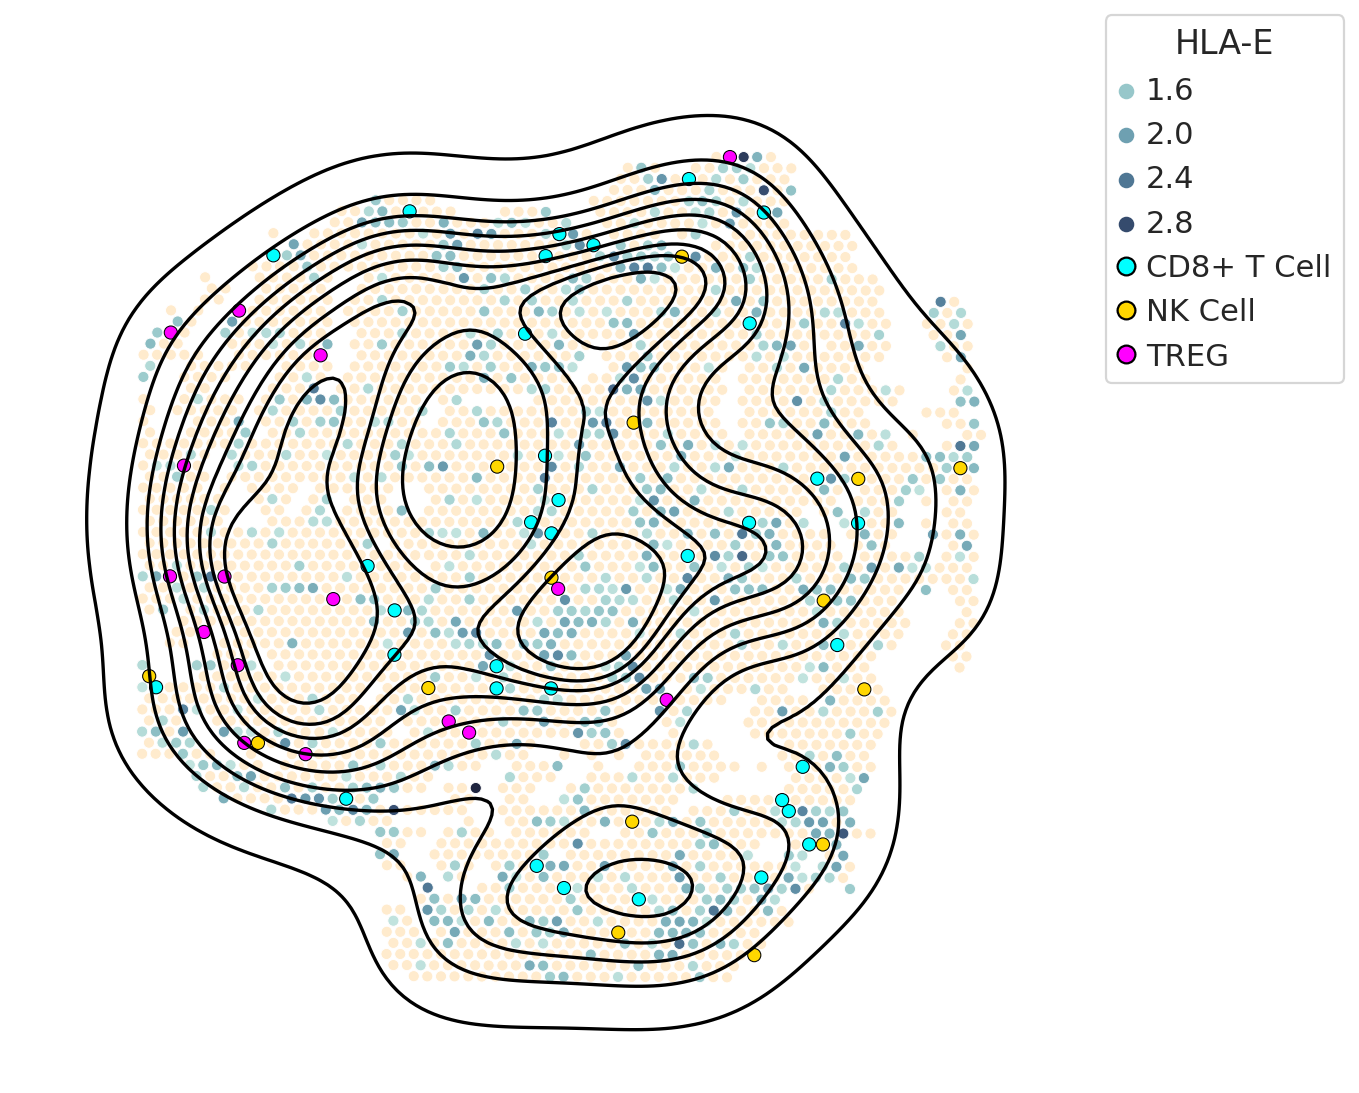

In [68]:
#######################################
# FIGURE 3 PANEL C: HLA-E + CD8 T Cells 
#######################################

# label any T cell regardless of infiltrated or not.
def label_T(row):    
    #if row['CD8+ T Cell bool'] == 1 or row['T Cell bool'] == 1:
    if row['CD8+ T Cell bool'] == 1:
        return 'Any T'
    else: 
        return 'No T' 
    
bin_16235.obs['T_label'] = binarized.obs.apply(lambda row: label_T(row), axis=1)

# subset on hlae
hlae_only = bin_16235[bin_16235.obs['HLA-E'] == True]
# KDE DF with binarized columns
kde_plot = pd.DataFrame(hlae_only.obsm['spatial'], columns = ('spatial_1', 'spatial_2'))

# Create custom blue color palette for the HLA-E Bright 
custom_blues = sns.color_palette("ch:start=0,rot=-.25", as_cmap=True)

with plt.rc_context({"figure.figsize": (8, 8), "figure.frameon": False}):
    fig, ax = plt.subplots(1)
    manual_spatial_plot = pd.DataFrame(bin_16235.obsm['spatial']).rename({0:'spatial_1',1:'spatial_2'},axis=1)
    manual_spatial_plot['T Cell'] = pd.DataFrame(bin_16235.obs['CD8+ T Cell bool']).reset_index()['CD8+ T Cell bool']
    manual_spatial_plot['TREG'] = pd.DataFrame(bin_16235.obs['TREG bool']).reset_index()['TREG bool']
    manual_spatial_plot['NK Cell'] = pd.DataFrame(bin_16235.obs['NK Cell bool']).reset_index()['NK Cell bool']
    manual_spatial_plot['HLA-E Expression'] = pd.DataFrame(scipy.sparse.csc_matrix.todense(bin_16235[:,bin_16235.var.index == 'HLA-E'].X))
    
    # Setting Background Color as blanched almond
    # T cell has only two options, and we color both the same. 
    # T cell is a random column. could use any column and set all options to be the same thing
    sns.scatterplot(
        data=manual_spatial_plot, 
        x="spatial_1", 
        y="spatial_2",
        s=25, 
        hue='T Cell',
        palette=['blanchedalmond', 'blanchedalmond'], 
        ax=ax,
        legend=False,
    )
    # HLA-E Bright (> 75th percentile)
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['HLA-E Expression'] > 1.25], 
        x="spatial_1", 
        y="spatial_2",
        s=25, 
        hue='HLA-E Expression', 
        palette=custom_blues, 
        ax=ax,
        legend=True,
    )
    # Coloring all T cells as red with black outline
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['T Cell'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=35, 
        hue='T Cell',
        palette=['aqua'],
        edgecolor="black",
        ax=ax,
        legend=False,
    )
    # NK cell 
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['NK Cell'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=35, 
        hue='NK Cell',
        palette=['gold'],
        edgecolor="black",
        ax=ax,
        legend=False,
    )
    # TREG 
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['TREG'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=35, 
        hue='TREG',
        palette=['fuchsia'],
        edgecolor="black",
        ax=ax,
        legend=False,
    )
        
    # HLA-E Contour
    sns.kdeplot(data=kde_plot.reset_index(), x="spatial_1", y="spatial_2", color='k', ax=ax)
    # NO border
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
# Window narrowing
plt.xlim(1200, 6000)
plt.ylim(1800, 6800)

# Plotting Options
plt.title(' ')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


plt.xlabel(' ')
plt.ylabel(' ')
# Custom Legend
leg = plt.legend(bbox_to_anchor=(1.05, 0.67))
ax = leg.axes
handles, labels = ax.get_legend_handles_labels()
new_elements = [
    Line2D([0], [0], marker='o', color='black', label='T Cell',markerfacecolor='aqua', markersize=8),
    Line2D([0], [0], marker='o', color='black', label='NK Cell',markerfacecolor='gold', markersize=8),
    Line2D([0], [0], marker='o', color='black', label='TREG',markerfacecolor='fuchsia', markersize=8),
]
for item in new_elements:
    handles.append(item)
labels.append('CD8+ T Cell')
labels.append('NK Cell')
labels.append('TREG')

leg._legend_box = None
leg._init_legend_box(handles, labels)
leg._set_loc((0,0.5))
leg.set_title('HLA-E')

plt.savefig(FIGURE_DIR+'/Figure 3 Panel C (CD8T cell).png',dpi=300, bbox_inches='tight')

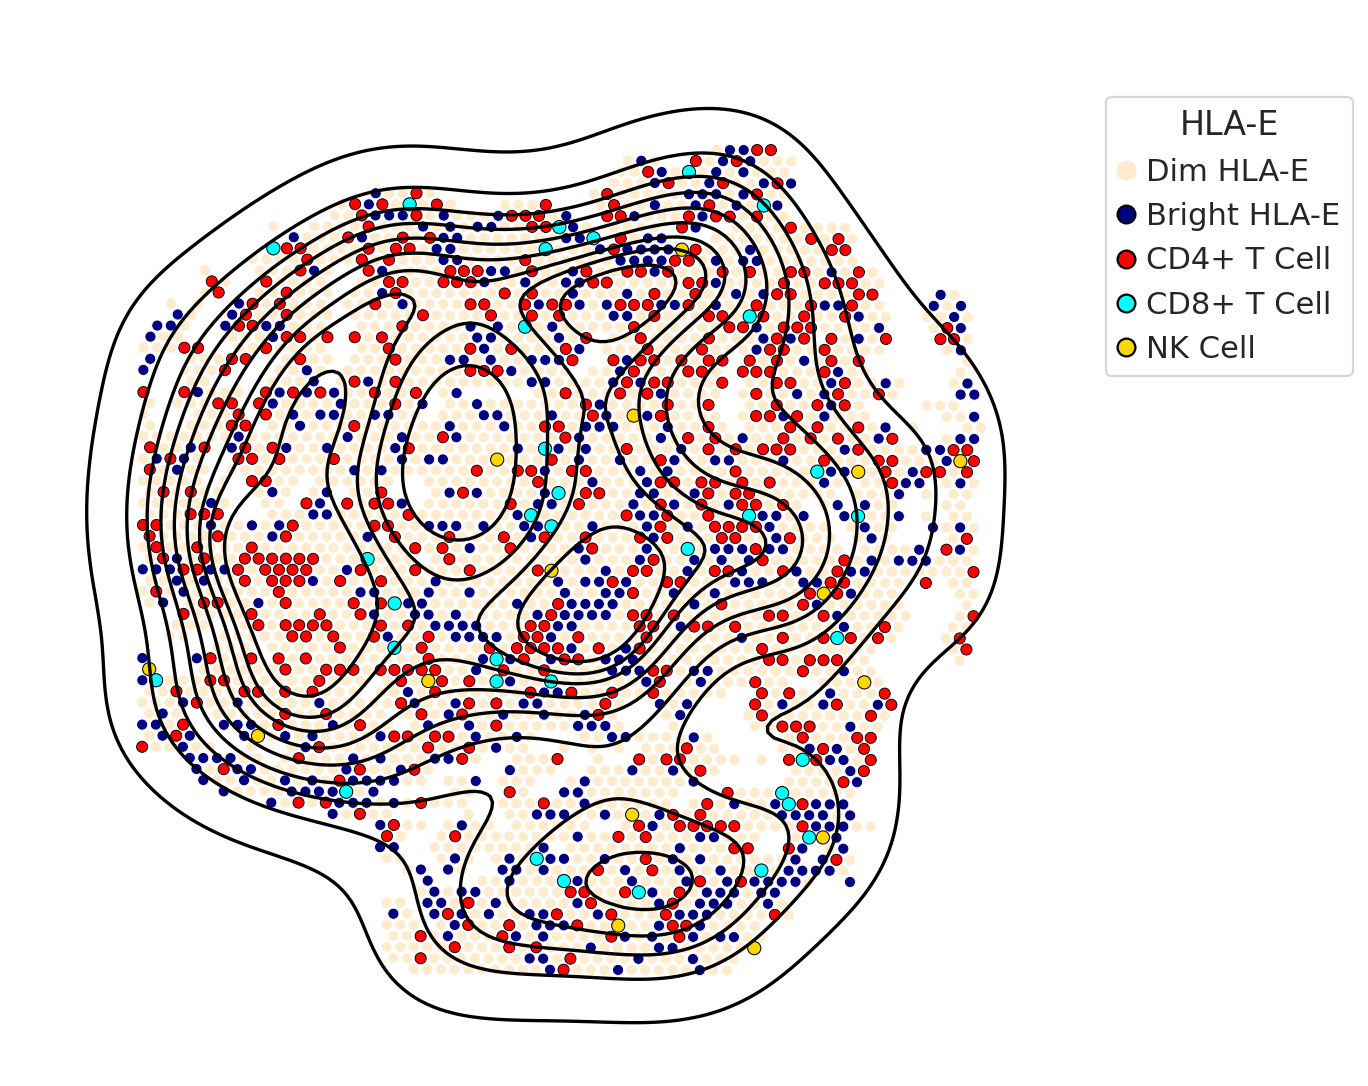

In [67]:
#######################################
# FIGURE 3 PANEL D: HLA-E + All T Cells 
#######################################

with plt.rc_context({"figure.figsize": (8, 8), "figure.frameon": False}):
    fig, ax = plt.subplots(1)
    manual_spatial_plot = pd.DataFrame(bin_16235.obsm['spatial']).rename({0:'spatial_1',1:'spatial_2'},axis=1)
    manual_spatial_plot['T Cell'] = pd.DataFrame(bin_16235.obs['CD4+ bool']).reset_index()['CD4+ bool']
    manual_spatial_plot['CD8+ T Cell'] = pd.DataFrame(bin_16235.obs['CD8+ T Cell bool']).reset_index()['CD8+ T Cell bool']
    manual_spatial_plot['NK Cell'] = pd.DataFrame(bin_16235.obs['NK Cell bool']).reset_index()['NK Cell bool']
    manual_spatial_plot['HLA-E Expression'] = pd.DataFrame(scipy.sparse.csc_matrix.todense(bin_16235[:,bin_16235.var.index == 'HLA-E'].X))
    
    # HLA-E Dim (> 75th percentile)
    # Setting Background Color as blanched almond
    # T cell has only two options, and we color both the same. 
    # T cell is a random column. could use any column and set all options to be the same thing
    sns.scatterplot(
        data=manual_spatial_plot, 
        x="spatial_1", 
        y="spatial_2",
        s=25, 
        hue='T Cell',
        palette=['blanchedalmond', 'blanchedalmond'], 
        ax=ax,
        legend=False,
    )
    # HLA-E Bright (> 75th percentile)
    # once again - T cell is a random column. I am coloring all of these the same
    # No HLA-E gradient here
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['HLA-E Expression'] > 1.25], 
        x="spatial_1", 
        y="spatial_2",
        s=25, 
        hue='T Cell',
        palette=['navy', 'navy'], 
        ax=ax,
        legend=True,
    )
    # Coloring all T cells as red with black outline
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['T Cell'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=25, 
        hue='T Cell',
        palette=['red'],
        edgecolor="black",
        ax=ax,
        legend=False,
    )
    # Coloring all CD8+T cells as red with black outline
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['CD8+ T Cell'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=35, 
        hue='CD8+ T Cell',
        palette=['aqua'],
        edgecolor="black",
        ax=ax,
        legend=False,
    )
    # NK cell 
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['NK Cell'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=35, 
        hue='NK Cell',
        palette=['gold'],
        edgecolor="black",
        ax=ax,
        legend=False,
    )
        
    # HLA-E Contour
    sns.kdeplot(data=kde_plot.reset_index(), x="spatial_1", y="spatial_2", color='k', ax=ax)
    # NO border
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
# Window narrowing
plt.xlim(1200, 6000)
plt.ylim(1800, 6800)

# Plotting Options
plt.title(' ')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


plt.xlabel(' ')
plt.ylabel(' ')
# Custom Legend
leg = plt.legend(bbox_to_anchor=(1.05, 0.67))
ax = leg.axes
handles, labels = ax.get_legend_handles_labels()
new_elements = [
    Line2D([0], [0], marker='o', color='blanchedalmond', label='High HLA-E',markerfacecolor='blanchedalmond', markersize=8),
    Line2D([0], [0], marker='o', color='black', label='High HLA-E',markerfacecolor='navy', markersize=8),
    Line2D([0], [0], marker='o', color='black', label='CD4+ T Cell',markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='black', label='CD8+ T Cell',markerfacecolor='aqua', markersize=8),
    Line2D([0], [0], marker='o', color='black', label='NK Cell',markerfacecolor='gold', markersize=8),
]
for item in new_elements:
    handles.append(item)
labels.append('Dim HLA-E')
labels.append('Bright HLA-E')
labels.append('CD4+ T Cell')
labels.append('CD8+ T Cell')
labels.append('NK Cell')


leg._legend_box = None
leg._init_legend_box(handles[2:], labels[2:])
leg._set_loc((0,0.5))
leg.set_title('HLA-E')

plt.savefig(FIGURE_DIR+'/Figure 3 Panel C (CD8T cell).png',dpi=300, bbox_inches='tight')

In [ ]:
#######################################
# FIGURE 3 PANEL F: CXCL 9 - 11 plot
#######################################
sc.tl.score_genes(bin_16235, ['CXCL9', 'CXCL10','CXCL11'], score_name = 'CXCLs')

# HLA-E Quantiles for 16235
hlae_measurements_16235 = pd.DataFrame(scipy.sparse.csc_matrix.todense(tumor_only[:,tumor_only.var.index == 'HLA-E'].X)).rename({0:'HLA-E'}, axis=1)
hlae_75_16235 = np.quantile(hlae_measurements_16235, 0.75)

# KDE DF with binarized columns
hlae_only = bin_16235[bin_16235.obs['HLA-E'] == True]
kde_plot = pd.DataFrame(hlae_only.obsm['spatial'], columns = ('spatial_1', 'spatial_2'))

# Custom color palette 
custom_blues = sns.color_palette("ch:start=0,rot=-.25", as_cmap=True)

sns.set_style("white")
with plt.rc_context({"figure.figsize": (8, 8), "figure.frameon": False}):
    fig, ax = plt.subplots(1)
    manual_spatial_plot = pd.DataFrame(bin_16235.obsm['spatial']).rename({0:'spatial_1',1:'spatial_2'},axis=1)
    manual_spatial_plot['T Cell'] = pd.DataFrame(bin_16235.obs['CD8+ T Cell bool']).reset_index()['CD8+ T Cell bool']
    manual_spatial_plot['TREG'] = pd.DataFrame(bin_16235.obs['TREG bool']).reset_index()['TREG bool']
    manual_spatial_plot['NK Cell'] = pd.DataFrame(bin_16235.obs['NK Cell bool']).reset_index()['NK Cell bool']
    manual_spatial_plot['CXCL9/10/11 Score'] = pd.DataFrame(bin_16235.obs['CXCLs']).reset_index()['CXCLs']
    manual_spatial_plot['HLA-E Expression'] = pd.DataFrame(scipy.sparse.csc_matrix.todense(bin_16235[:,bin_16235.var.index == 'HLA-E'].X))
    high_hlae = manual_spatial_plot[manual_spatial_plot['HLA-E Expression']> hlae_75_16235]
    sns.scatterplot(
        data=high_hlae, 
        x="spatial_1", 
        y="spatial_2",
        s=25, 
        hue='CXCL9/10/11 Score', 
        #palette=custom_blues, 
        palette='Reds', 
        ax=ax,
        legend=True,
    )
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['T Cell'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=35, 
        hue='T Cell',
        palette=['aqua'],
        edgecolor="black",
        ax=ax,
        legend=False,
    )
    
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['NK Cell'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=35, 
        hue='NK Cell',
        palette=['gold'],
        edgecolor="black",
        ax=ax,
        legend=False,
    )
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['TREG'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=35, 
        hue='TREG',
        palette=['fuchsia'],
        edgecolor="black",
        ax=ax,
        legend=False,
    )
    
    sns.kdeplot(data=kde_plot.reset_index(), x="spatial_1", y="spatial_2", color='k', ax=ax)
    # NO border
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    
plt.xlim(1200, 6000)
plt.ylim(1800, 6800)

plt.title(' ')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


plt.xlabel(' ')
plt.ylabel(' ')
leg = plt.legend(bbox_to_anchor=(1.05, 0.67))

ax = leg.axes
handles, labels = ax.get_legend_handles_labels()
new_elements = [
    Line2D([0], [0], marker='o', color='black', label='CD8+ T Cell',markerfacecolor='aqua', markersize=8),
    Line2D([0], [0], marker='o', color='black', label='NK Cell',markerfacecolor='gold', markersize=8),
    Line2D([0], [0], marker='o', color='black', label='TREG',markerfacecolor='fuchsia', markersize=8),
]
for item in new_elements:
    handles.append(item)
labels.append('CD8+ T Cell')
labels.append('NK Cell')
labels.append('TREG')

leg._legend_box = None
leg._init_legend_box(handles, labels)
leg._set_loc((0,0.5))
leg.set_title('CXCL9/10/11')

plt.savefig(FIGURE_DIR+'/Figure 3 Panel D (CD8+ Only).png',dpi=200, bbox_inches='tight')

# Heatmaps

In [ ]:
##################
# Figure 3 Panel G
##################

def label_neighboring_T(row):
    '''
    To assign HLA-E labels
    '''
    # 4 and below
    if row['Neighbor_count:n_neigh_CD4+'] < 5: 
        return 'Low T Cell Neighbor'
    # 7 and above
    elif row['Neighbor_count:n_neigh_CD4+'] > 6:
        return 'High T Cell Neighbor'
    # 5 and 6
    else: 
        return 'Middle T Cell Neighbor'

# add neighboring T category    
hlae_HL_tumor.obs['neighboring_t_category'] = hlae_HL_tumor.obs.apply(lambda row: label_neighboring_T(row), axis=1)
# Filter to only low e low t and high e high t
paired_hlae_tumor_comparison = hlae_HL_tumor[(
        (hlae_HL_tumor.obs['neighboring_t_category'] == 'Low T Cell Neighbor') & 
        (hlae_HL_tumor.obs['HLA-E Label'] == 'Low')
    )
    |
    (
        (hlae_HL_tumor.obs['neighboring_t_category'] == 'High T Cell Neighbor') & 
        (hlae_HL_tumor.obs['HLA-E Label'] == 'High')
    )]

checkpoint_ligands = {
    'Inhibitory':['CD47','CD274','PDCD2','HLA-A','HLA-B','HLA-C',], #'lgals9', 
    'Stimulatory':['CD58',],
    'Inf. Recep': ['IFNGR1','IFNGR2'],
    'Inf. Pathway': ['JAK1','JAK2', 'STAT1','STAT3','IRF1','IRF9','SOCS1', 'FAS'],
}

paired_hlae_tumor_comparison.obs['HLA-E Label'] = pd.Categorical(paired_hlae_tumor_comparison.obs['HLA-E Label'], ["Low", "High"])

mp = sc.pl.matrixplot(
    paired_hlae_tumor_comparison, 
    checkpoint_ligands,
    groupby='HLA-E Label',
    figsize=(4,7),
    colorbar_title='Mean Z-Score', 
    layer='scaled', 
    vmin=-1, 
    vmax=1,
    return_fig=True,
    show=False,
    cmap='RdBu_r', 
    swap_axes=True
)

mp.add_totals().show()
mp.savefig(FIGURE_DIR+'/Figure 3 Panel G.png', dpi = 250)

sc.tl.rank_genes_groups(
    paired_hlae_tumor_comparison, 
    groupby='HLA-E Label', 
    method='wilcoxon', 
)

logfold_df = sc.get.rank_genes_groups_df(paired_hlae_tumor_comparison, group=None)

logfold_df[
    (logfold_df['group'] == 'High') &
    (logfold_df['names'].isin(['CXCL9','CXCL10','CXCL11','IFNGR1','IFNGR2', 'JAK1','JAK2', 'STAT1','STAT3','IRF1','IRF9','SOCS1', 'FAS'])) & 
    (logfold_df['pvals_adj'] < 0.05)
].to_csv(FIGURE_DIR+'/neighboring all T logfold.csv')

In [ ]:
###############################
# Figure 3 Extra Panels H and I
###############################
# n_neigh_CD4
# n_neigh_CD8
# n_neigh_treg
# n_neigh_NK

def label_neighboring_cytolytic(row):
    '''
    To assign HLA-E labels
    '''
    # 4 and below
    cytolytic_count = row['Neighbor_count:n_neigh_NK']+row['Neighbor_count:n_neigh_CD8+']
    if cytolytic_count == 0: 
        return 'No cytolytic neighbors'
    else: 
        return 'Cytolytic neighbors'

# add neighboring T category    
hlae_HL_tumor.obs['neighboring_cytolytic_category'] = hlae_HL_tumor.obs.apply(lambda row: label_neighboring_cytolytic(row), axis=1)
# Filter to only low e low t and high e high t
hlae_cytolytic_comparison = hlae_HL_tumor[(
        (hlae_HL_tumor.obs['neighboring_cytolytic_category'] == 'No cytolytic neighbors') & 
        (hlae_HL_tumor.obs['HLA-E Label'] == 'Low')
    )
    |
    (
        (hlae_HL_tumor.obs['neighboring_cytolytic_category'] == 'Cytolytic neighbors') & 
        (hlae_HL_tumor.obs['HLA-E Label'] == 'High')
    )]

checkpoint_ligands = {
    'Inhibitory':['CD47','CD274','PDCD2','HLA-A','HLA-B','HLA-C',], #'lgals9', 
    'Stimulatory':['CD58',],
    'Inf. Recep': ['IFNGR1','IFNGR2'],
    'Inf. Pathway': ['JAK1','JAK2', 'STAT1','STAT3','IRF1','IRF9','SOCS1', 'FAS'],
}

hlae_cytolytic_comparison.obs['HLA-E Label'] = pd.Categorical(hlae_cytolytic_comparison.obs['HLA-E Label'], ["Low", "High"])

mp = sc.pl.matrixplot(
    hlae_cytolytic_comparison, 
    checkpoint_ligands,
    groupby='HLA-E Label',
    figsize=(4,7),
    colorbar_title='Mean Z-Score', 
    layer='scaled', 
    vmin=-1, 
    vmax=1,
    return_fig=True,
    show=False,
    cmap='RdBu_r', 
    swap_axes=True
)

mp.add_totals().show()
mp.savefig(FIGURE_DIR+'/Figure 3 Panel H (HLAE high low for all cytolytic).png', dpi = 250)

sc.tl.rank_genes_groups(
    hlae_cytolytic_comparison, 
    groupby='HLA-E Label', 
    method='wilcoxon', 
)

logfold_df = sc.get.rank_genes_groups_df(hlae_cytolytic_comparison, group=None)

logfold_df[
    (logfold_df['group'] == 'High') &
    (logfold_df['names'].isin(['CXCL9','CXCL10','CXCL11','IFNGR1','IFNGR2', 'JAK1','JAK2', 'STAT1','STAT3','IRF1','IRF9','SOCS1', 'FAS'])) & 
    (logfold_df['pvals_adj'] < 0.05)
].to_csv(FIGURE_DIR+'/neighboring cytolytic logfold.csv')

# CXCL 9 - 11 & distance experiments

In [ ]:
###################
# Distance
###################

dist_dfs = []
for sample_id in list(set(binarized.obs.sample_id)):
    adata_temp = binarized[(binarized.obs.sample_id == sample_id)]
    tumor_cells = adata_temp[
        (adata_temp.obs['Tumor Cell bool'] == 1)
    ]
    cytolytic_cells = adata_temp[
        (adata_temp.obs['CD8+ T Cell bool'] == 1) | 
        (adata_temp.obs['NK Cell bool'] == 1) 
    ]
    cytolytic_dist_list = []
    for i in range(0,cytolytic_cells.shape[0]):
        cytolytic_idx = cytolytic_cells[i,:].obs.index[0]
        cytolytic_location = cytolytic_cells[i,:].obsm['spatial']
        cytolytic_dists = scipy.spatial.distance.cdist(XA=cytolytic_location, XB=tumor_cells.obsm['spatial'])
        cytolytic_dist_list.append(cytolytic_dists[0])
    temp_df = pd.DataFrame(cytolytic_dist_list).T
    temp_df.index = tumor_cells.obs.index
    temp_df['dist_closest_cytolytic'] = temp_df.min(axis=1)
    dist_dfs.append(temp_df)
tumor_only.obs['nearest_cytolytic_cell'] = pd.concat(dist_dfs)['dist_closest_cytolytic']

sc.tl.score_genes(tumor_only, ['CXCL9','CXCL10','CXCL11'], score_name='CXCLs')

def label_quantile(row): 
    quantile = None
    for quant in range(1,11,1):
        cutoff = np.quantile(tumor_only.obs['nearest_cytolytic_cell'], quant/10)
        if row['nearest_cytolytic_cell'] < cutoff:
            if quantile:
                continue
            else: 
                quantile = quant*10
    if not quantile: 
        quantile = 100
    return quantile

cxcl_high = np.quantile(tumor_only.obs['CXCLs'], 0.75)
tumor_only_cxcl_high = tumor_only[tumor_only.obs['CXCLs'] > cxcl_high]

tumor_only_cxcl_high.obs['percentile_by_pop'] = tumor_only_cxcl_high.obs.apply(lambda row: label_quantile(row), axis=1)

#########################
# Stripplot CXCL Distance
########################
temp = ['nearest_cytolytic_cell', 'CXCLs', 'bcg_status', 'percentile_by_pop']
df = tumor_only_cxcl_high.obs[temp]

sns.set(font_scale=1.3, rc={'figure.figsize':(4.5,6)})
sns.set_style("white")

ax = sns.stripplot(data=df, x="percentile_by_pop", y="CXCLs", hue='bcg_status', dodge=True,  size=5, )
plt.ylabel('Tumor CXCL Score')
plt.xlabel('Distance Percentile To Closest NK/CD8+ T')
plt.yticks([0,1,2])
ax.set_xticklabels(['10','','','','50','','','','','100'])

custom_lines = [Line2D([0], [0], label='BCG Unresponsive', color='#2777B4', lw=8),
                Line2D([0], [0], label='BCG Naive', color='#FF7F0E', lw=8),
                Line2D([0], [0], label='BCG/PD1 Unresponsive', color='Green', lw=8)]

plt.legend(title='BCG Status', bbox_to_anchor=(0.2,1), handles=custom_lines)
plt.savefig(FIGURE_DIR+'/figure 3 panel XX1 cxcl proximity scatter.png', bbox_inches='tight',dpi=200)

tumor_only_cxcl_high.obs['percentile_by_pop'] = pd.Categorical(tumor_only_cxcl_high.obs['percentile_by_pop'])
sc.tl.rank_genes_groups(
    tumor_only_cxcl_high, 
    groupby='percentile_by_pop',
    method='wilcoxon', 
)

logfold_df = sc.get.rank_genes_groups_df(tumor_only_cxcl_high, group=None)

logfold_df[
    (logfold_df['names'].isin(['CXCL9','CXCL10','CXCL11'])) &
    (logfold_df['pvals_adj']< 0.05)
].to_csv(FIGURE_DIR+'/percentile_by_population.csv')

In [ ]:
#########################
# Stripplot CXCL Distance
########################

temp = ['nearest_cytolytic_cell', 'bcg_status']
df = tumor_only.obs[temp]
df['CXCL9'] = tumor_only[:,'CXCL9'].X.toarray()
df['CXCL10'] = tumor_only[:,'CXCL10'].X.toarray()
df['CXCL11'] = tumor_only[:,'CXCL11'].X.toarray()

df['bcg_status'] = df['bcg_status'].replace({
    'Post-BCG':'BCG Unresponsive', 
    'Pre-BCG': 'BCG Naive', 
    'Post BCG, PD1': 'BCG/PD-1 Unresponsive', 
})

df['bcg_status'] = pd.Categorical(df['bcg_status'], ['BCG Unresponsive', 'BCG/PD-1 Unresponsive', 'BCG Naive',])

sns.set(font_scale=1.1, rc={'figure.figsize':(3.5,6)})
sns.set_style("white")

for cxcl in ['CXCL9', 'CXCL10', 'CXCL11']:
    sns.scatterplot(
        data=df, 
        x="nearest_cytolytic_cell", 
        y=cxcl, 
        hue='bcg_status', 
        palette=['#FF7F0E','Green','#2777B4',],
        legend=None
    ),
    plt.ylabel('Tumor Expression of {}'.format(cxcl))
    plt.xlabel('Dist. to Closest NK/CD8+ T')
    plt.savefig(FIGURE_DIR+'/figure 3 {} proximity scatter.png'.format(cxcl), transparent=True, bbox_inches='tight',dpi=200)


In [ ]:
###################
# Histogram
###################

sns.set(font_scale=1.1, rc={'figure.figsize':(3.5,6)})
sns.set_style("white")


tumor_only.obs['BCG Status'] = tumor_only.obs['bcg_status'].replace({
    'Post-BCG':'BCG Unresponsive', 
    'Pre-BCG': 'BCG Naive', 
    'Post BCG, PD1': 'BCG/PD-1 Unresponsive', 
})

# flipping this order so that BCG naive sits on the bottom
tumor_only.obs['BCG Status'] = pd.Categorical(tumor_only.obs['BCG Status'], ['BCG Unresponsive', 'BCG/PD-1 Unresponsive', 'BCG Naive',])

sns.histplot(
    tumor_only.obs, 
    x='nearest_cytolytic_cell', 
    hue='BCG Status', 
    alpha=1, 
    stat='percent', 
    multiple='stack',
    palette=['#FF7F0E','Green','#2777B4',],
    legend=None
)
plt.xlabel('Dist To Nearest NK/CD8+')
plt.ylabel('Percent of Tumor Visium Spots')
plt.yticks([0,5,10,15,20])
plt.savefig(
    FIGURE_DIR+'/Supplemental figure 3: tumor histogram by cytolytic proximity.png',
    transparent=True, 
    bbox_inches='tight',
    dpi=200
)


In [ ]:
sc.tl.rank_genes_groups(
    tumor_only, 
    reference='BCG Naive',
    groupby='bcg_status',
    method='wilcoxon', 
)

logfold_df = sc.get.rank_genes_groups_df(tumor_only, group=None)

logfold_df[
    (logfold_df['names'].isin(['CXCL9','CXCL10','CXCL11', 'STAT1'])) &
    (logfold_df['group'] == 'BCG Unresponsive')
].sort_values('logfoldchanges', ascending=False).head(30)

# SUPPLEMENTAL FIGURES

In [ ]:
##############################################
# Spatial Supplement: T cells colored by CXCR4
#############################################

#Subset to one column
bin_16235 = binarized[binarized.obs.sample_id == '16235']
hlae_col = pd.DataFrame(scipy.sparse.csc_matrix.todense(bin_16235[:,bin_16235.var.index == 'HLA-E'].X > 0)).rename({0:'HLA-E'}, axis=1)
hlae_col.index = bin_16235.obs.index
bin_16235.obs['HLA-E'] = hlae_col

# subset on hlae
hlae_only = bin_16235[bin_16235.obs['HLA-E'] == True]
# KDE DF with binarized columns
kde_plot = pd.DataFrame(hlae_only.obsm['spatial'], columns = ('spatial_1', 'spatial_2'))

custom_blues = sns.color_palette("ch:start=0,rot=-.25", as_cmap=True)

import matplotlib
# Make the goddamn figure
sns.set_style("white")
with plt.rc_context({"figure.figsize": (8, 8), "figure.frameon": False}):
    fig, ax = plt.subplots(1)
    manual_spatial_plot = pd.DataFrame(bin_16235.obsm['spatial']).rename({0:'spatial_1',1:'spatial_2'},axis=1)
    #manual_spatial_plot['T Cell'] = pd.DataFrame(bin_16235.obs['CD8+ T Cell bool']).reset_index()['CD8+ T Cell bool']
    manual_spatial_plot['T Cell'] = pd.DataFrame(bin_16235.obs['T Cell bool']).reset_index()['T Cell bool']
    manual_spatial_plot['NK Cell'] = pd.DataFrame(bin_16235.obs['NK Cell bool']).reset_index()['NK Cell bool']
    manual_spatial_plot['HLA-E Expression'] = pd.DataFrame(scipy.sparse.csc_matrix.todense(bin_16235[:,bin_16235.var.index == 'HLA-E'].X))
    manual_spatial_plot['CXCR4'] = pd.DataFrame(scipy.sparse.csc_matrix.todense(bin_16235[:,bin_16235.var.index == 'CXCR4'].X))
    sns.scatterplot(
        data=manual_spatial_plot, 
        x="spatial_1", 
        y="spatial_2",
        s=25, 
        hue='T Cell',
#         edgecolor="black",
        palette=['blanchedalmond', 'blanchedalmond'], 
        ax=ax,
        legend=False,
    )
    manual_spatial_plot = manual_spatial_plot[manual_spatial_plot['HLA-E Expression'] > 1.25]
    sns.scatterplot(
        data=manual_spatial_plot, 
        x="spatial_1", 
        y="spatial_2",
        s=25, 
        hue='HLA-E Expression', 
        palette=custom_blues, 
        ax=ax,
        legend=True,
    )
    # T cell hue here 
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['T Cell'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=25, 
        hue='CXCR4',
        palette='Reds',
        edgecolor="black",
        ax=ax,
        legend=False,
    )
    
    sns.scatterplot(
        data=manual_spatial_plot[manual_spatial_plot['NK Cell'] == 1 ], 
        x="spatial_1", 
        y="spatial_2",
        s=25, 
        hue='NK Cell',
        palette=['fuchsia'],
        edgecolor="black",
        ax=ax,
        legend=False,
    )
    
    sns.kdeplot(data=kde_plot.reset_index(), x="spatial_1", y="spatial_2", color='k', ax=ax)
    # NO border
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    
plt.xlim(1200, 6000)
plt.ylim(1800, 6800)

plt.title(' ')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


plt.xlabel(' ')
plt.ylabel(' ')
leg = plt.legend(bbox_to_anchor=(1.05, 0.67))

ax = leg.axes
handles, labels = ax.get_legend_handles_labels()
new_elements = [
    Line2D([0], [0], marker='o', color='red', label='T Cell CXCR4 Expression',markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='hotpink', label='NK Cell',markerfacecolor='hotpink', markersize=8),
]
for item in new_elements:
    handles.append(item)
labels.append('T Cell')
labels.append('NK Cell')

leg._legend_box = None
leg._init_legend_box(handles, labels)
leg._set_loc((0,0.5))
leg.set_title('HLA-E')

plt.savefig(FIGURE_DIR+'/Supplement: T cell + CXCR4.png',dpi=200, bbox_inches='tight')

In [ ]:
###############################
# Supplemental: Pre-BCG Heatmap
###############################

tumor_only.obs = tumor_only.obs.rename({'HLA-E': 'HLA-E Level'},axis=1)
tumor_only_under13 = tumor_only[
    (tumor_only.obs['Neighbor_count:Total T count'].isin([0,1,2,3,4,5,6,7,8,9,10,11,12,13])) & 
    (tumor_only.obs.bcg_status == 'Pre-BCG')
]
tumor_only_under13.layers['scaled'] = sc.pp.scale(tumor_only_under13, copy=True).X
tumor_only_under13.obs['Neighbor_count:Total T count'] = pd.Categorical(tumor_only_under13.obs['Neighbor_count:Total T count'])

sc.set_figure_params(fontsize=15)
checkpoint_ligands = {
    'Inhibitory':['CD47','CD274','PDCD2','HLA-A','HLA-B','HLA-C', 'HLA-E',], #'lgals9', 
    'Stimulatory':['CD58',],
    'Inf. Recep': ['IFNGR1','IFNGR2'],
    'Inf. Pathway': ['JAK1','JAK2', 'STAT1','STAT3','IRF1','IRF9','SOCS1', 'FAS'],
}

with plt.rc_context({"figure.dpi": (100)}):
    mp = sc.pl.matrixplot(
        tumor_only_under13, 
        var_names=checkpoint_ligands,
        figsize=(9,7),
        groupby='Neighbor_count:Total T count',
        colorbar_title='Mean Z-Score', 
        layer='scaled', 
        dendrogram=False,
        swap_axes=True,
        vmin=-1, 
        vmax=1,
        return_fig=True,
        cmap='RdBu_r', 
    )
    mp.add_totals().show()
    mp.savefig(FIGURE_DIR+'/Supplemental 3 Panel E.png')

In [ ]:
########################################
# Supplemental: CD8+ T cell Only Heatmap
#######################################

tumor_only.obs['Neighbor_count:Total CD8T'] = pd.Categorical(tumor_only.obs['Neighbor_count:Total CD8T'])

with plt.rc_context({"figure.dpi": (100)}):
    mp = sc.pl.matrixplot(
        tumor_only, 
        var_names=checkpoint_ligands,
        figsize=(4,7),
        groupby='Neighbor_count:Total CD8T',
        colorbar_title='Mean Z-Score', 
        layer='scaled', 
        dendrogram=False,
        swap_axes=True,
        vmin=-1, 
        vmax=1,
        return_fig=True,
        cmap='RdBu_r', 
    )
    mp.add_totals().show()
    mp.savefig(FIGURE_DIR+'/Supplemental Figure 3: Checkered Heatmap (CD8 T Only).png')


In [ ]:
##################
# Figure 3 Panel E
##################

hlae_df = pd.DataFrame(hlae_HL_tumor.obs[['HLA-E Label', 'neighboring_t_category', 'bcg_status']].value_counts()).reset_index()

hlae_df['neighboring_t_category'] = pd.Categorical(
    hlae_df['neighboring_t_category'], 
    ['Low T Cell Neighbor', 'Middle T Cell Neighbor', 'High T Cell Neighbor'])

hlae_df['HLA-E Label'] = pd.Categorical(
    hlae_df['HLA-E Label'], 
    ['Low', 'High',])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,8), sharey=True)
sns.set(rc={'figure.figsize':(6,8.27), },font_scale=1.4,)
sns.set_style("white")
for case, ax in zip(['Pre-BCG', 'Post-BCG'], [ax1, ax2]):
    fig = sns.barplot(
        data=hlae_df[hlae_df['bcg_status'] == case], 
        x='HLA-E Label',
        y=0,
        hue='neighboring_t_category',
        palette = 'rocket_r',
        ax=ax,
        ci=None,
    )
    ax.legend_.remove()
    
    fig.set_title(case)
ax1.set_ylabel('N Visium Spots')
ax2.set_ylabel('')
leg = plt.legend(bbox_to_anchor=(1.3,1), fontsize=20,title='Neigboring T Cells',title_fontsize=20)
plt.savefig(FIGURE_DIR+'/Supplemental Figure 3: histogram of HLAE, T cell cases.png',bbox_inches='tight',dpi=250 )

In [ ]:
#######################################################################################
# Figure 3: Z scaled Heatmap from perspective of Cytolytic cells with neighboring tumor
#######################################################################################

# binarized.obs['Neighbor_count:n_neigh_tumors']
# cytolytic = binarized[(binarized.obs['NK Cell bool'] == 1) | (binarized.obs['CD8+ T Cell bool'] == 1)]
cytolytic = binarized[
    ((binarized.obs['NK Cell bool'] == 1) | 
    (binarized.obs['CD8+ T Cell bool'] == 1) | 
    (binarized.obs['T Cell bool'] == 1)) &
    (binarized.obs['Tumor Cell bool'] == 0)
]
cytolytic.obs['Neighbor_count:n_neigh_tumors'] = pd.Categorical(cytolytic.obs['Neighbor_count:n_neigh_tumors'])

def bucket_neighboring_tumor(row):
    '''
    To bucket neighboring tumor
    '''
    # 4 and below
    cytolytic_count = row['Neighbor_count:n_neigh_tumors']
    if cytolytic_count < 6: 
        return 'Low Neighboring Tumor'
    elif cytolytic_count > 12:
        return 'High Neighboring Tumor'
    else: 
        return 'Middle Neighboring Tumor'

# add neighboring T category    
cytolytic.obs['neighboring_tumor_category'] = cytolytic.obs.apply(lambda row: bucket_neighboring_tumor(row), axis=1)
cytolytic = cytolytic[cytolytic.obs['neighboring_tumor_category'].isin(['Low Neighboring Tumor', 'High Neighboring Tumor'])]
print(cytolytic.obs['neighboring_tumor_category'].value_counts())

###################
# Differential gene
###################
sc.tl.rank_genes_groups(
    cytolytic,
    groupby='neighboring_tumor_category',
    use_raw=False
)

logfold_df = sc.get.rank_genes_groups_df(cytolytic, group=None)
# Uppercase the names column so we can string match
logfold_df.names = logfold_df.names.str.upper()

logfold_df.sort_values('logfoldchanges', ascending=False)
logfold_df = logfold_df[~logfold_df.names.str.startswith('AC0')]
# logfold_df[logfold_df.names.isin(['NKG7','ICOSLG', 'CD44','CD2', 'SIGLEC15','SIGLEC1', 'CXCR4'])]
logfold_df.sort_values('group', ascending=False).head(10)
gene_list = logfold_df[(logfold_df['pvals_adj'] < 0.05) &
           (logfold_df['group'] =='High Neighboring Tumor') &
           (logfold_df['logfoldchanges'] > 0)
          ].sort_values('logfoldchanges', ascending=False).names.tolist()

# GSEA
import gseapy as gp
enr_infiltrated_upregulated = gp.enrichr(gene_list=gene_list,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

enr_infiltrated_upregulated.results[enr_infiltrated_upregulated.results['Adjusted P-value'] < 0.05]

###################
# Differential gene
###################

cytolytic.layers['scaled'] = sc.pp.scale(cytolytic, copy=True).X
cytolytic.obs['neighboring_tumor_category'] = pd.Categorical(
    cytolytic.obs['neighboring_tumor_category'], 
    ['Low Neighboring Tumor', 'High Neighboring Tumor'])


sc.set_figure_params(fontsize=15)
cytolytic_ligands = {
    'Inhibitory':[ 'SIGLEC15','SIGLEC1'], #'lgals9', 
    'Stimulatory':['NKG7','ICOSLG', 'CD44','CD2'],
    'Chemokine receptors': ['CXCR4'],
#     'Inf. Pathway': ['JAK1','JAK2', 'STAT1','STAT3','IRF1','IRF9','SOCS1', 'FAS'],
}

with plt.rc_context({"figure.dpi": (100)}):
    mp = sc.pl.matrixplot(
        cytolytic, 
        var_names=cytolytic_ligands,
        figsize=(6,3),
        groupby='neighboring_tumor_category',
        colorbar_title='Mean Z-Score', 
        layer='scaled', 
        dendrogram=False,
        swap_axes=True,
        vmin=-1, 
        vmax=1,
        return_fig=True,
        cmap='RdBu_r', 
    )
    mp.add_totals().show()
#     mp.savefig(FIGURE_DIR+'/Figure 3 Panel F (Total T).png')
